<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Original-Hodgkin-&amp;-Huxley-Paper" data-toc-modified-id="Original-Hodgkin-&amp;-Huxley-Paper-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Original Hodgkin &amp; Huxley Paper</a></span></li><li><span><a href="#Gerstner's-Nuerodynamics-Book" data-toc-modified-id="Gerstner's-Nuerodynamics-Book-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Gerstner's Nuerodynamics Book</a></span></li><li><span><a href="#Minimal-HH-models" data-toc-modified-id="Minimal-HH-models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Minimal HH-models</a></span></li><li><span><a href="#Plot-for-Paper" data-toc-modified-id="Plot-for-Paper-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot for Paper</a></span></li></ul></div>

In [1]:
import numpy as np
from brian2 import *
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Ubuntu'

# Colorblind-friendly colors
C0 = '#0B7ABA' # nearly blue 
C1 = '#BD0000' # nearly red
C2 = '#FFB700' # nearly yellow
C3 = '#A0A0A0' # nearly gray    
C4 = '#84358C'

In [2]:
def run_sim(Is, sim_time=300*ms, gap_time = 100*ms):
    group = NeuronGroup(1, eqs,method='exponential_euler', dt=0.1*ms)
    group.v = 0
    group.h = 0.6 # equilibrium value
    group.m = 0.1 # equilibrium value
    group.n = 0.3 # equilibrium value
    monitor = StateMonitor(group, True,True)
    

    # Initialize the simulation
    group.I = '0*uamp'
    run(gap_time/2.)

    for i in Is:
        # Apply some microAmp and rest
        group.I = str(i)+'*uamp'
        run(sim_time)
        group.I = '0*uamp'
        run(gap_time)
    
    # finalize the simulation
#     group.I = '0*uamp'
#     run(gap_time/2)
    
    return monitor
    
def plot_nicely(monitor, save_name, for_paper=False):
    if for_paper:
        lws = [2.5, 2, 1.5]
    else:
        lws = [1, 1, 1]
        
    axd = plt.figure(figsize=(8,5)).subplot_mosaic(
        """
        A
        B
        C
        """,
        gridspec_kw={"height_ratios": [1, 1, .2]},
    )

    ax = axd['A']
    ax.plot(monitor.t/ms, (monitor.v[0])/mV, color='k', linewidth=lws[1])
    ax.set_ylabel('V [mV]') 

    ax = axd['B'] 
    ax.set_ylabel('gating variables') 
    
    ax.plot(monitor.t/ms, monitor.h[0], label='h', linewidth=lws[0], color= C0)
    ax.plot(monitor.t/ms, monitor.m[0], label='m', linewidth=lws[1], color= C1)
    ax.plot(monitor.t/ms, monitor.n[0], label='n', linewidth=lws[2], color= C2)
    ax.legend()

    ax = axd['C'] 
    ax.set_ylabel(r'I [$\mu A$]') 
    ax.plot(monitor.t/ms, monitor.I[0]/(1*uamp), color='k', linewidth=lws[1])
    ax.set_xlabel('time [ms]') 

    for idx in axd:
        axd[idx].set_xlim(0,monitor.t[-1]/ms)
        if idx!='C':
            axd[idx].set_xticklabels([])
    plt.tight_layout()
    plt.savefig(save_name+'.jpg',dpi=300, bbox_inches='tight')

# Original Hodgkin & Huxley Paper
Hodgkin, A.L., Huxley, A.F., 1952. A quantitative description of membrane current and its application to conduction and excitation in nerve. The Journal of Physiology 117, 500–544. https://doi.org/10.1113/jphysiol.1952.sp004764.

**Note**: Voltages here are differences from the equilibrium voltage. cf. paper above.

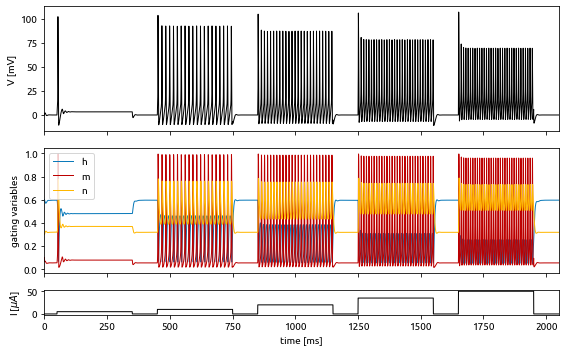

In [3]:
start_scope()

area = 1*cm**2 
Cm = 1*ufarad*cm**-2 * area
El = 10.613*mV
ENa = 115* mV
EK = -12*mV
gl = 0.3*msiemens*cm**-2 * area
gKd = 36*msiemens*cm**-2 * area
gNa = 120*msiemens*cm**-2 * area

eqs ="""
dv/dt = (-INa- IKd - gl*(v-El) + I)/Cm : volt

I: amp
IKd = gKd*n**4*(v-EK) : amp
INa = gNa*m**3*h*(v-ENa) : amp

dn/dt = alphan * (1-n) - betan * n : 1
dm/dt = alpham * (1-m) - betam * m : 1
dh/dt = alphah * (1-h) - betah * h : 1

alphan = (0.01*10)/exprel((-v+10.*mV)/(10.*mV))/ms : Hz
betan = (0.125)*exp(-v/(80.*mV))/ms : Hz

alpham = (0.1*10)/exprel((-v+25.*mV)/(10.*mV))/ms : Hz
betam = 4*exp(-v/(18.*mV))/ms : Hz

alphah = 0.07*exp(-v/(20.*mV))/ms : Hz
betah = 1./(1+exp((-v+30.*mV)/(10.*mV)))/ms : Hz
"""

# monitor = run_sim(Is = [2., 5., 10.])
# plot_nicely(monitor, 'HH_for_paper')
monitor = run_sim(Is = [5., 10., 20., 35., 50])
plot_nicely(monitor, 'HH_orig')

# Gerstner's Nuerodynamics Book
Gerstner, W., Kistler, W.M., Naud, R., Paninski, L., 2014. Neuronal Dynamics: From Single Neurons to Networks and Models of Cognition. Cambridge University Press.
https://neuronaldynamics.epfl.ch/online/Ch2.S2.html

In addition I used got help from [its python exercise module](https://neuronaldynamics-exercises.readthedocs.io/en/latest/_modules/neurodynex3/hodgkin_huxley/HH.html#simulate_HH_neuron) for conventions on the reversal potentials. 

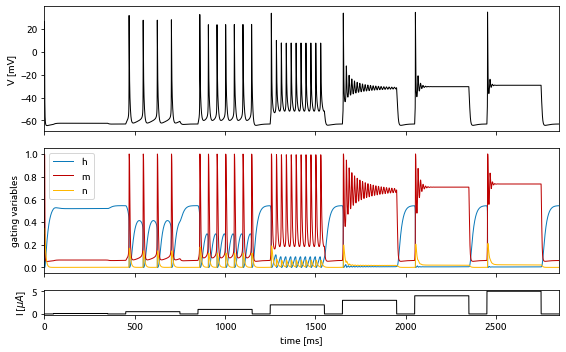

In [4]:
start_scope()

area = 1*cm**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
ENa = 55* mV
EK = -77*mV
# vT = -56.2*mV
gl = 0.3*msiemens*cm**-2 * area
gKd = 35*msiemens*cm**-2 * area
gNa = 40*msiemens*cm**-2 * area

eqs ="""
dv/dt = (-INa- IKd - gl*(v-El) + I)/Cm : volt

I: amp
IKd = gKd*n**4*(v-EK) : amp
INa = gNa*m**3*h*(v-ENa) : amp

dn/dt = alphan * (1-n) - betan * n : 1
dm/dt = alpham * (1-m) - betam * m : 1
dh/dt = alphah * (1-h) - betah * h : 1

alphan = (0.02*9)/exprel(-(v-25.*mV)/(9.*mV))/ms : Hz
betan = (0.002*9)/exprel((v-25.*mV)/(9.*mV))/ms : Hz

alpham = (0.182*9)/exprel(-(v+35.*mV)/(9.*mV))/ms : Hz
betam = (0.124*9)/exprel((v+35.*mV)/(9.*mV))/ms : Hz

alphah = 0.25*exp(-(v+90.*mV)/(12.*mV))/ms : Hz
betah = 0.25*exp((v+34.*mV)/(12.*mV))/ms : Hz
"""

monitor = run_sim(Is = [.1, .5, 1, 2, 3, 4, 5])
plot_nicely(monitor, 'HH_gerstner')

>**Note**: Do you spot this strange behavior at high current amplitudes? I think it is because of the numerical solver. It worth investigating. Let me know if you figured out the reason. Thanks! :) 

# Minimal HH-models
Pospischil, M., Toledo-Rodriguez, M., Monier, C., Piwkowska, Z., Bal, T., Frégnac, Y., Markram, H., Destexhe, A., 2008. Minimal Hodgkin–Huxley type models for different classes of cortical and thalamic neurons. Biol Cybern 99, 427–441. https://doi.org/10.1007/s00422-008-0263-8

**Note**: Only Na and Kd currents are included for fair comparison.

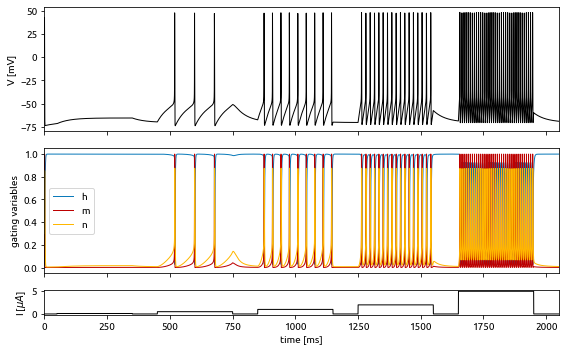

In [5]:
start_scope()

area = 1*cm**2
Cm = 1*ufarad*cm**-2 * area
El = -70.3*mV
ENa = 50* mV
EK = -90*mV
vT = -56.2*mV
gl = 2.05e-5*siemens*cm**-2 * area
gKd = 0.006*siemens*cm**-2 * area
gNa = 0.056*siemens*cm**-2 * area


eqs ="""
dv/dt = (-INa- IKd - gl*(v-El) + I)/Cm : volt
I: amp
IKd= gKd*n**4*(v-EK) : amp
INa  = gNa*m**3*h*(v-ENa) : amp

dm/dt = alpham * (1-m) - betam * m : 1
dh/dt = alphah * (1-h) - betah * h : 1
dn/dt = alphan * (1-n) - betan * n : 1

alpham = (0.32*4)/exprel(-(v-vT-13.*mV)/(4.*mV))/ms : Hz
betam = (0.28*5)/exprel((v-vT-40.*mV)/(5.*mV))/ms : Hz

alphah = 0.128*exp(-(v-vT-17.*mV)/(18.*mV))/ms : Hz
betah = 4./(1+exp(-(v-vT-40.*mV)/(5.*mV)))/ms : Hz

alphan = (0.032*5)/exprel(-(v-vT-10.*mV)/(5.*mV))/ms : Hz
betan = (0.5)*exp(-(v-vT-10.*mV)/(40.*mV))/ms : Hz
"""

monitor = run_sim(Is = [.1, 0.5, 1, 2, 5])
plot_nicely(monitor, 'HH_minimal')

# Plot for Paper
I used the original HH model.

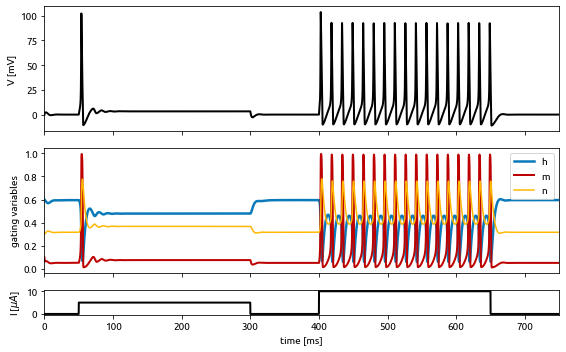

In [6]:
start_scope()

area = 1*cm**2 
Cm = 1*ufarad*cm**-2 * area
El = 10.613*mV
ENa = 115* mV
EK = -12*mV
gl = 0.3*msiemens*cm**-2 * area
gKd = 36*msiemens*cm**-2 * area
gNa = 120*msiemens*cm**-2 * area

eqs ="""
dv/dt = (-INa- IKd - gl*(v-El) + I)/Cm : volt

I: amp
IKd = gKd*n**4*(v-EK) : amp
INa = gNa*m**3*h*(v-ENa) : amp

dn/dt = alphan * (1-n) - betan * n : 1
dm/dt = alpham * (1-m) - betam * m : 1
dh/dt = alphah * (1-h) - betah * h : 1

alphan = (0.01*10)/exprel((-v+10.*mV)/(10.*mV))/ms : Hz
betan = (0.125)*exp(-v/(80.*mV))/ms : Hz

alpham = (0.1*10)/exprel((-v+25.*mV)/(10.*mV))/ms : Hz
betam = 4*exp(-v/(18.*mV))/ms : Hz

alphah = 0.07*exp(-v/(20.*mV))/ms : Hz
betah = 1./(1+exp((-v+30.*mV)/(10.*mV)))/ms : Hz
"""

# monitor = run_sim(Is = [2., 5., 10.])
# plot_nicely(monitor, 'HH_for_paper')
monitor = run_sim(Is = [5., 10.], sim_time=250*ms,)
plot_nicely(monitor, 'HH_for_paper', for_paper=True)